In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [2]:
# 使用 transforms.Compose 定义预处理操作，包括 ToTensor、Normalize 等；
# 使用 torchvision.datasets 下载 MNIST 数据集，同时作用之前定义的变换；
# 使用 DataLoader 对数据进行加载，批处理大小为 64，同时打乱数据加载
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])
train_set = torchvision.datasets.MNIST(root = "data",
                            transform=transform,
                            train = True,
                            download = True)
test_set = torchvision.datasets.MNIST(root="data",
                           transform = transform,
                           train = False,
                           download = False)
#装载数据
train_loader = torch.utils.data.dataloader.DataLoader(dataset=train_set,
                                                      batch_size = 64, shuffle = True)
test_loader = torch.utils.data.dataloader.DataLoader(dataset=test_set,
                                                     batch_size = 64, shuffle = True)

In [3]:
#生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.linear1 = nn.Linear(100,256*7*7)
        self.bn1 = nn.BatchNorm1d(256*7*7)
        self.deconv1 = nn.ConvTranspose2d(256,128, kernel_size=(3,3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128,64, kernel_size=(4,4),stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64,1,kernel_size=(4,4),stride=2, padding=1)
    def forward(self,x):
        x = F.relu(self.linear1(x)); x = self.bn1(x); x = x.view(-1, 256,7,7)
        x = F.relu(self.deconv1(x)); x = self.bn2(x)
        x = F.relu(self.deconv2(x)); x = self.bn3(x)
        x = torch.tanh(self.deconv3(x))
        return x

In [4]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.bn = nn .BatchNorm2d(128 )
        self.fc = nn.Linear(128*6*6,1)
    def forward(self,x):
        x = F.dropout2d(F.leaky_relu(self.conv1(x)))
        x = F.dropout2d(F.leaky_relu(self.conv2(x)))
        x = self.bn(x)
        x = x.view(-1,128*6*6)
        x = torch.sigmoid(self.fc(x))
        return x

In [5]:
#实例化生成器和判别器
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gen = Generator().to(device)
dis = Discriminator().to(device)

In [6]:
#将损失函数loss_function 设置为二值交叉熵损失
loss_function = nn.BCELoss()
#将生成器和判别器的优化器均设为 Adam，并分别命名为 d_optim 和g_optim，学习率 lr 均为 1e-4
d_optim = optim.Adam(dis.parameters(), lr=1e-4)
g_optim = optim.Adam(gen.parameters(), lr=1e-4)

In [7]:
def generate_and_show_images(model, test_input, device):
    """图像生成和显示"""
    if device=='cuda':
        predictions = np.squeeze(model(test_input).detach().cpu().numpy())
    else:
        predictions = np.squeeze(model(test_input).detach().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i + 1)
        plt.imshow((predictions[i] + 1) / 2,cmap='gray')
        plt.axis("off")
    plt.show( )

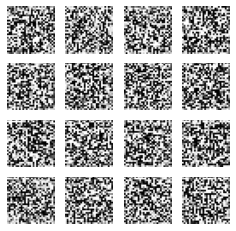

In [8]:
test_input = torch.randn(16,100,device=device)
generate_and_show_images(gen, test_input, device) #测试生成器

In [9]:
D_loss = [] # 判别器的损失值
G_loss = [] # 生成器的损失值
# 定义训练函数
def train(dataloader, epochs):
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            # 训练判别器
            real_labels = torch.ones(imgs.size(0),1).to(device)
            fake_labels = torch.zeros(imgs.size(0),1).to(device)
            # 将真实图片和假图片分别输入判别器，并计算损失
            outputs = dis(imgs)
            d_loss_real = loss_function(outputs, real_labels)
            z = torch.randn(imgs.size(0),100).to(device)
            fake_imgs = gen(z)
            outputs = dis(fake_imgs)
            d_loss_fake = loss_function(outputs, fake_labels)
            d_loss = d_loss_real + d_loss_fake # 损失求和
            dis.zero_grad() # 清空梯度
            d_loss.backward() # 反向传播
            d_optim.step() # 更新参数
            
            # 训练生成器
            z = torch.randn(imgs.size(0),100).to(device)
            fake_imgs = gen(z)
            outputs = dis(fake_imgs)
            g_loss = loss_function(outputs, real_labels)
            gen.zero_grad() # 清空梯度
            g_loss.backward() # 反向传播
            g_optim.step() # 更新参数
            
            # 打印损失值
            if i % 500 == 0:
                print("Epoch:{}, iteration:{}, d_loss:{:.3f}, g_loss:{:.3f}".format(epoch, i, d_loss, g_loss))
                D_loss.append(d_loss)
                G_loss.append(g_loss)

In [10]:
#训练模型
epochs=50
train(train_loader, epochs)

Epoch:0, iteration:0, d_loss:1.381, g_loss:0.725
Epoch:0, iteration:500, d_loss:0.539, g_loss:1.453
Epoch:1, iteration:0, d_loss:0.514, g_loss:1.947
Epoch:1, iteration:500, d_loss:0.506, g_loss:2.021
Epoch:2, iteration:0, d_loss:0.305, g_loss:1.750
Epoch:2, iteration:500, d_loss:0.456, g_loss:2.279
Epoch:3, iteration:0, d_loss:0.650, g_loss:1.751
Epoch:3, iteration:500, d_loss:0.582, g_loss:2.723
Epoch:4, iteration:0, d_loss:0.535, g_loss:2.038
Epoch:4, iteration:500, d_loss:0.723, g_loss:3.643
Epoch:5, iteration:0, d_loss:0.472, g_loss:2.962
Epoch:5, iteration:500, d_loss:0.553, g_loss:1.841
Epoch:6, iteration:0, d_loss:0.431, g_loss:1.360
Epoch:6, iteration:500, d_loss:0.667, g_loss:2.631
Epoch:7, iteration:0, d_loss:0.902, g_loss:1.566
Epoch:7, iteration:500, d_loss:0.409, g_loss:1.293
Epoch:8, iteration:0, d_loss:0.493, g_loss:2.012
Epoch:8, iteration:500, d_loss:0.747, g_loss:2.606
Epoch:9, iteration:0, d_loss:0.595, g_loss:3.677
Epoch:9, iteration:500, d_loss:0.642, g_loss:2.401


In [15]:
print(torch.cuda.is_available())
print(device)


True
cuda


In [19]:
print(type(D_loss))

<class 'list'>


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

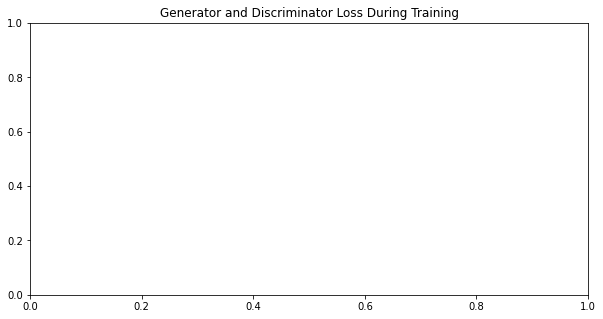

In [20]:
# 绘制损失函数曲线
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
#把 GPU tensor 转换成 Numpy 变量的时候，需要先将 tensor 转换到 CPU 去，因为 Numpy 是 CPU-only 的
plt.plot(G_loss,label="G")
plt.plot(D_loss.cpu(),label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

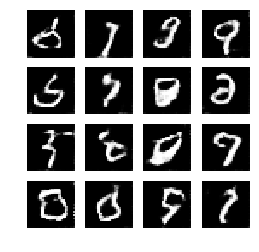

In [ ]:
# 生成器生成的图片
test_input = torch.randn(16,100,device=device)
generate_and_show_images(gen, test_input, device)

In [ ]:
# 生成指定数字的图片
def generate_images(model, test_input, device, num):
    if device=='cuda':
        predictions = np.squeeze(model(test_input).detach().cpu().numpy())
    else:
        predictions = np.squeeze(model(test_input).detach().numpy())
    fig = plt.figure(figsize=(4,4))
    for i in range(num):
        plt.subplot(4,4,i + 1)
        plt.imshow((predictions[i] + 1) / 2,cmap='gray')
        plt.axis("off")
    plt.show( )

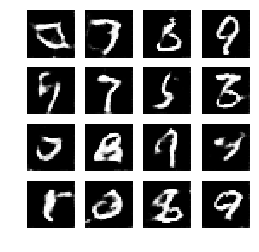

In [ ]:
#生成数字 2
test_input = torch.randn(16,100,device=device)
test_input[:,2] = 1 
generate_images(gen, test_input, device, 16)

In [ ]:
# 生成数字3
test_input = torch.randn(16,100,device=device)
test_input[:,3] = 1
generate_images(gen, test_input, device, 16)